<a href="https://colab.research.google.com/github/brendontj/CC-Fraud-Detection/blob/master/cc_fraud_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, mean_squared_error, accuracy_score, plot_roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from math import sqrt

In [2]:
data = pd.read_csv('creditcard.csv')
print('Quantidade de linhas do dataset {}'.format(data.shape[0]))
data.head()

Quantidade de linhas do dataset 23858


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [3]:
df = data.dropna()
df = df.drop(columns="Time") # Removing column time, because is not relevant
df['ID']= np.arange(1,len(df.Class)+1)
print('Quantidade de linhas do dataset sem valor Null/NaN/NaT {}'.format(df.shape[0]))
df.head()

Quantidade de linhas do dataset sem valor Null/NaN/NaT 23857


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,ID
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0,1
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0,2
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0,3
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0,4
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0,5


In [4]:
x_train,  x_test, y_train, y_test = train_test_split(df.drop(['ID', 'Class'], axis=1), df['Class'], test_size=0.20, random_state = 0)
print('Dados de treino {}\n'.format(x_train.shape))
print('Dados de teste  {}\n'.format(x_test.shape))

Dados de treino (19085, 29)

Dados de teste  (4772, 29)



In [5]:
df_train = x_train.copy()
df_train['Class'] = y_train
df_test = x_test.copy()
df_test['Class'] = y_test

In [6]:
df_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000,19085.000000
mean,-0.236772,0.198382,0.726499,0.239917,-0.188034,0.079633,-0.130309,0.015287,0.497788,-0.165021,0.597453,-0.877309,0.532985,0.444761,0.013757,0.001147,0.251971,-0.057363,-0.053124,0.040892,-0.044070,-0.140559,-0.038644,0.015030,0.127107,0.027766,0.014103,0.003428,73.909619,0.003563
std,1.895541,1.540977,1.711270,1.439334,1.455422,1.339294,1.349176,1.403008,1.271955,1.194679,1.175176,1.535478,1.199786,1.287788,0.964141,0.948546,1.172971,0.850662,0.811300,0.653393,0.844311,0.647233,0.546102,0.585942,0.436505,0.521057,0.403077,0.264091,217.257371,0.059586
min,-30.552380,-40.978852,-31.103685,-5.172595,-42.147898,-23.496714,-26.548144,-41.484823,-7.175097,-14.166795,-2.767470,-17.631606,-3.588761,-18.822087,-3.875765,-12.227189,-18.587366,-8.061208,-4.932733,-13.694584,-20.262054,-8.593642,-26.751119,-2.836627,-7.495741,-1.338556,-8.567638,-9.617915,0.000000,0.000000
25%,-0.960634,-0.381711,0.289253,-0.666421,-0.770681,-0.667905,-0.592600,-0.168153,-0.330014,-0.637077,-0.232257,-2.069387,-0.301502,-0.148169,-0.544873,-0.484661,-0.253007,-0.523257,-0.541910,-0.157963,-0.255861,-0.566933,-0.173207,-0.325527,-0.136217,-0.338633,-0.066346,-0.009699,5.990000,0.000000
50%,-0.286741,0.191124,0.874180,0.213919,-0.220605,-0.184323,-0.066333,0.026670,0.423484,-0.218745,0.576382,-0.572361,0.486708,0.423255,0.144244,0.065916,0.212266,-0.035591,-0.055549,-0.026094,-0.107095,-0.113489,-0.048366,0.065368,0.165206,-0.046154,0.006596,0.019929,18.000000,0.000000
75%,1.165972,0.843582,1.506235,1.117499,0.325554,0.467060,0.452101,0.280656,1.260377,0.274353,1.367061,0.310342,1.424268,1.297493,0.691338,0.555747,0.712864,0.441016,0.455801,0.156880,0.065076,0.269320,0.075171,0.400936,0.407601,0.316337,0.096208,0.077180,65.850000,0.000000
max,1.960497,16.713389,4.101716,11.927512,34.099309,22.529298,36.677268,20.007208,10.392889,12.701539,11.669205,4.846452,4.465413,7.692209,3.635042,6.098529,9.253526,4.295648,4.555359,15.815051,22.614889,5.805795,13.876221,3.695503,5.525093,3.517346,11.135740,4.783772,7879.420000,1.000000


In [7]:
df_test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000,4772.000000
mean,-0.248609,0.200738,0.729062,0.283403,-0.190276,0.095414,-0.139463,0.053503,0.505833,-0.174354,0.591471,-0.906341,0.548777,0.465202,0.002135,-0.003268,0.233208,-0.060014,-0.059905,0.040452,-0.029657,-0.124201,-0.037601,0.008012,0.131180,0.026458,0.009751,0.010949,74.244399,0.004191
std,1.889290,1.501310,1.778657,1.447111,1.376215,1.282864,1.275205,1.274942,1.283376,1.204665,1.188061,1.566577,1.205301,1.291981,0.984165,0.962841,1.218721,0.863192,0.827145,0.610516,0.808246,0.634471,0.438287,0.599009,0.433479,0.516876,0.392911,0.282046,193.760529,0.064610
min,-29.876366,-15.732974,-30.558697,-4.449606,-21.665654,-7.574798,-20.081391,-27.156906,-6.333685,-13.175198,-2.621346,-17.769143,-3.315213,-19.214325,-4.152532,-10.266609,-17.542030,-6.792638,-4.192616,-7.157627,-14.031579,-8.555808,-10.477978,-2.512377,-2.224853,-1.203625,-8.260909,-4.455921,0.000000,0.000000
25%,-0.952104,-0.352859,0.279740,-0.628712,-0.755823,-0.650286,-0.608143,-0.164326,-0.334011,-0.637452,-0.242808,-2.075831,-0.294996,-0.101651,-0.566825,-0.476516,-0.270396,-0.518608,-0.542483,-0.159377,-0.245446,-0.540064,-0.178554,-0.328346,-0.125063,-0.332381,-0.065848,-0.008770,6.470000,0.000000
50%,-0.299251,0.197995,0.875875,0.224234,-0.210457,-0.167510,-0.066597,0.028763,0.416136,-0.215604,0.584070,-0.623424,0.498204,0.444267,0.119002,0.070257,0.192126,-0.027814,-0.060834,-0.022354,-0.098326,-0.100655,-0.049845,0.057763,0.163670,-0.047838,0.006072,0.020211,18.520000,0.000000
75%,1.160535,0.838362,1.504448,1.140604,0.321085,0.508027,0.446035,0.308202,1.269972,0.269180,1.336552,0.305042,1.428051,1.291256,0.704521,0.553721,0.710449,0.432755,0.443481,0.158220,0.074755,0.281486,0.070651,0.399357,0.408429,0.308516,0.089213,0.077907,66.985000,0.000000
max,1.628532,16.434525,3.934998,11.885313,11.974269,7.074414,10.602036,19.587773,10.370658,12.174400,12.018913,3.408259,3.842704,6.940484,2.740343,3.764085,7.893393,4.115560,3.365632,7.207552,22.599543,3.635997,6.681144,3.658746,2.156042,3.087444,4.173387,4.860769,3588.640000,1.000000


In [8]:
df_train['Class'].value_counts()

0.0    19017
1.0       68
Name: Class, dtype: int64

In [9]:
df_test['Class'].value_counts()

0.0    4752
1.0      20
Name: Class, dtype: int64

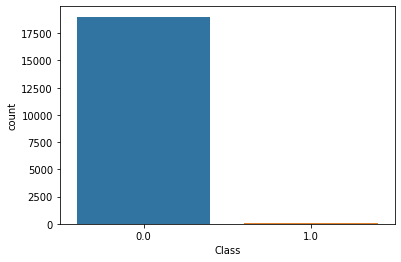

In [10]:
ax = sns.countplot(x="Class", data=df_train)

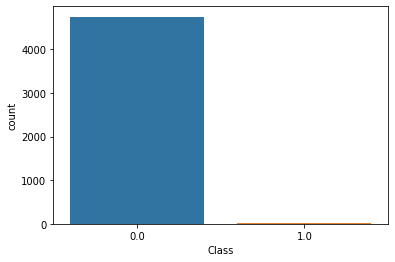

In [11]:
bx = sns.countplot(x="Class", data=df_test)

In [12]:
n_fraudulent_transactions = df_train['Class'].value_counts()[1]
print('Quantidade de transações fraudulentas no dataset de treino ({}) representando um total de ({})% do dataset'.format(n_fraudulent_transactions, (n_fraudulent_transactions/df_train.shape[0])*100))
n_fraudulent_transactions = df_test['Class'].value_counts()[1]
print('Quantidade de transações fraudulentas no dataset de teste ({}) representando um total de ({})% do dataset'.format(n_fraudulent_transactions, (n_fraudulent_transactions/df_test.shape[0])*100))

Quantidade de transações fraudulentas no dataset de treino (68) representando um total de (0.356300759758973)% do dataset
Quantidade de transações fraudulentas no dataset de teste (20) representando um total de (0.4191114836546521)% do dataset


In [13]:
mic = mutual_info_classif(x_train, y_train)
mic

array([0.0079244 , 0.01103538, 0.01298734, 0.0154607 , 0.00776974,
       0.0104176 , 0.0108529 , 0.00642284, 0.01304414, 0.01546621,
       0.01551707, 0.01643671, 0.00091408, 0.01626348, 0.00092921,
       0.01240332, 0.01585787, 0.01003825, 0.00227247, 0.00570593,
       0.0097629 , 0.0008971 , 0.0043584 , 0.00278652, 0.00617967,
       0.00427311, 0.00782176, 0.00798014, 0.00719303])

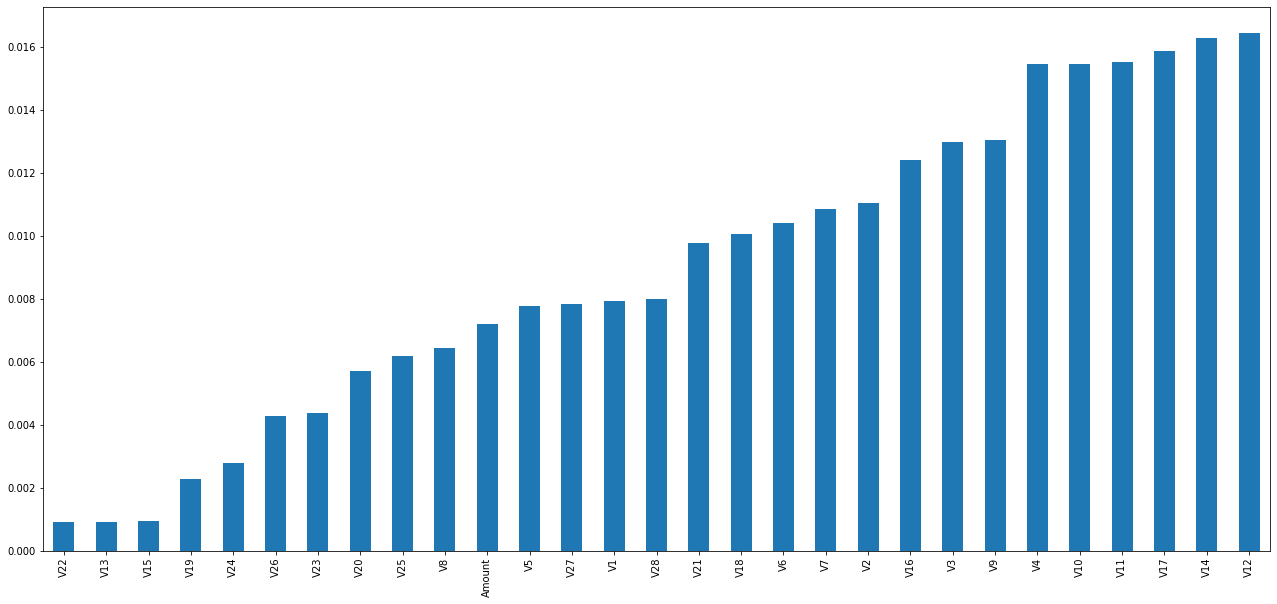

In [14]:
mic = pd.Series(mic)
mic.index = x_train.columns
mic = mic.sort_values(ascending = True)
mic.plot.bar(figsize=(22,10))

In [15]:
selection = SelectKBest(mutual_info_classif, k= 20).fit(x_train, y_train)
X_train = x_train[x_train.columns[selection.get_support()]]
X_test = x_test[x_test.columns[selection.get_support()]]

In [46]:
def plot_Kfold_cross_validation_curves(x_data, y_data):
  cv = StratifiedKFold(n_splits=5)

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(x_data, y_data)):
      rf.fit(x_data.iloc[train], y_data.iloc[train])
      viz = plot_roc_curve(rf, x_data.iloc[test], y_data.iloc[test],
                          name='ROC fold {}'.format(i),
                          alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="ROC for K fold cross-validation curves")
  ax.legend(loc="lower right")
  plt.show()

# Random Forest

- Treino com sample de treino

In [16]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Treino

- Relatório de classificação da predição com o modelo Random forest com o sample de treino

In [17]:
predictions = rf.predict(X_train)
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19017
         1.0       1.00      1.00      1.00        68

    accuracy                           1.00     19085
   macro avg       1.00      1.00      1.00     19085
weighted avg       1.00      1.00      1.00     19085



- Matriz de confusão dos valores preditos com o conjunto de treino

In [18]:
pd.crosstab(y_train, predictions, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0.0,1.0,All
Real,,,
0.0,19017,0,19017
1.0,0,68,68
All,19017,68,19085


- Validação cruzada utilizando 5 pastas

In [19]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
scores

array([0.99921404, 0.99869007, 0.99973801, 0.99895206, 0.99842808])

- Media dos scores obtidos

In [20]:
scores.mean()

0.9990044537594971

- Acurácia do modelo

In [21]:
accuracy_score(y_train, predictions)

1.0

- Root Mean Squared Error (RMSE) 

In [22]:
rmse = sqrt(mean_squared_error(y_train, predictions))
rmse

0.0

- Curva ROC

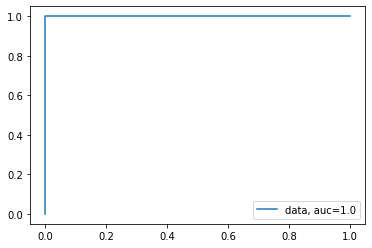

In [47]:
fpr, tpr, _ = roc_curve(y_train, predictions)
roc_auc_scr =  roc_auc_score(y_train, predictions)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

 - Curvas da K fold cross-validation

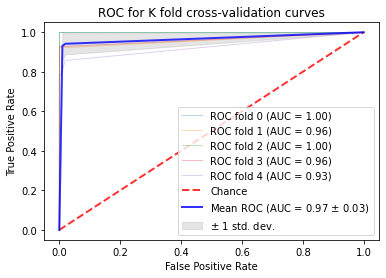

In [50]:
plot_Kfold_cross_validation_curves(X_train, y_train)

## Teste

- Predição do sample de teste

In [ ]:
predictions_test = rf.predict(X_test)

- Relatório de classificação da predição com o modelo Random forest com o sample de teste

In [ ]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.93      0.79      0.86       101

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



- Matriz de confusão dos valores preditos com o conjunto de teste

In [ ]:
pd.crosstab(y_test, predictions_test, rownames=['Real'],colnames=['Predito'],margins=True) 

Predito,0,1,All
Real,,,
0,56855,6,56861
1,21,80,101
All,56876,86,56962


- Validação cruzada utilizando 5 pastas com conjunto de teste

In [ ]:
scores = cross_val_score(rf, X_test, predictions_test, cv=5, scoring='accuracy')
scores

array([0.99973668, 0.99964891, 0.99982444, 0.9995611 , 0.99991222])

- Media dos scores obtidos com o conjunto de teste

In [ ]:
scores.mean()

0.9996839995507788

- Acurácia do modelo

In [ ]:
accuracy_score(y_test, predictions_test)

0.9995259997893332

- Root Mean Squared Error (RMSE)

In [ ]:
rmse = sqrt(mean_squared_error(y_test, predictions_test))
rmse

0.021771545895199088

- Curva ROC, conjunto de teste

In [44]:
fpr, tpr, _ = roc_curve(y_test, predictions_test)
roc_auc_scr =  roc_auc_score(y_test, predictions_test)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

NameError: ignored

- Curvas da K fold cross-validation dados de teste

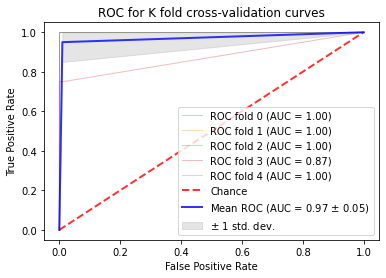

In [51]:
plot_Kfold_cross_validation_curves(X_test, y_test)

# KNN 

In [59]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## Treino

In [60]:
y_pred = knn.predict(X_train)

1.0

In [ ]:
accuracy_score(y_train, y_pred)

In [61]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19017
         1.0       1.00      1.00      1.00        68

    accuracy                           1.00     19085
   macro avg       1.00      1.00      1.00     19085
weighted avg       1.00      1.00      1.00     19085



In [62]:
pd.crosstab(y_train, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

Predito,0.0,1.0,All
Real,,,
0.0,19017,0,19017
1.0,0,68,68
All,19017,68,19085


In [64]:
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
scores

array([0.99895206, 0.99921404, 0.99921404, 0.99921404, 0.99842808])

In [65]:
scores.mean()

0.9990044537594971

In [66]:
accuracy_score(y_train, y_pred)

1.0

In [67]:
rmse = sqrt(mean_squared_error(y_train, y_pred))
rmse

0.0

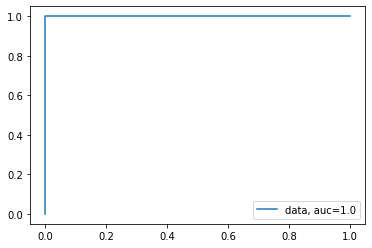

In [68]:
fpr, tpr, _ = roc_curve(y_train, y_pred)
roc_auc_scr =  roc_auc_score(y_train, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

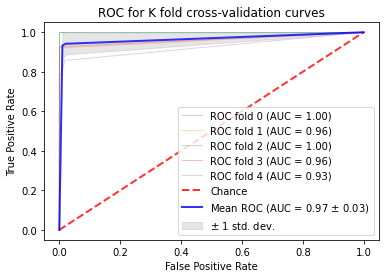

In [69]:
plot_Kfold_cross_validation_curves(X_train, y_train)

## Teste

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
pd.crosstab(y_test, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

In [ ]:
scores = cross_val_score(knn, X_test, y_test, cv=5, scoring='accuracy')
scores

In [ ]:
scores.mean()

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_scr =  roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

In [ ]:
plot_Kfold_cross_validation_curves(X_test, y_test)

# MLPClassifier

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

## Treino

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

In [ ]:
 print(classification_report(y_train, y_pred))

In [ ]:
pd.crosstab(y_train, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
scores

In [ ]:
scores.mean()

In [ ]:
accuracy_score(y_train, y_pred)

In [ ]:
rmse = sqrt(mean_squared_error(y_train, y_pred))
rmse

In [ ]:
fpr, tpr, _ = roc_curve(y_train, y_pred)
roc_auc_scr =  roc_auc_score(y_train, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

In [ ]:
plot_Kfold_cross_validation_curves(X_train, y_train)

## Teste

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
 print(classification_report(y_test, y_pred))

In [ ]:
pd.crosstab(y_test, y_pred, rownames=['Real'],colnames=['Predito'],margins=True)

In [ ]:
scores = cross_val_score(clf, X_test, y_test, cv=5, scoring='accuracy')
scores

In [ ]:
scores.mean()

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_scr =  roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data, auc="+str(roc_auc_scr))
plt.legend(loc=4)
plt.show()

In [ ]:
plot_Kfold_cross_validation_curves(X_test, y_test)